In [256]:
import pyximport
import numpy as np
pyximport.install(setup_args={"include_dirs": np.get_include()},
                  reload_support=True)
from algorithms.knn_neighborhood import UserKNN
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from scipy.stats import skew as sklearn_skew

In [372]:
def compute_delta_maes(base, model):
    delta_maes = dict()
    for uid in model.mae_u:
        if uid in base.mae_u:
            #delta_maes[uid] = model.mae_u[uid] / base.mae_u[uid] if base.mae_u[uid] > 0 else model.mae_u[uid]
            delta_maes[uid] = model.mae_u[uid]
    return delta_maes
    
def compute_delta_exposures(base, model):
    delta_exposures = dict()
    for uid in model.exposure_u:
        if uid in base.exposure_u:
            #delta_exposures[uid] = model.exposure_u[uid] / base.exposure_u[uid] if base.exposure_u[uid] > 0 else model.exposure_u[uid]
            delta_exposures[uid] = model.exposure_u[uid]
    
    return delta_exposures

def compute_delta_ratios(delta_maes, delta_exposures):
    """uids = set(delta_maes.keys()).intersection(delta_exposures.keys())
    delta_ratios = dict()
    for uid in uids:
        delta_ratios[uid] = delta_maes[uid] / delta_exposures[uid] if delta_exposures[uid] > 0 else delta_maes[uid]"""
    
    return delta_exposures
    
    return delta_ratios

In [373]:
data_df = pd.read_csv("data/ml-100k/u.data", sep="\t", names=["user_id", "item_id", "rating", "timestamp"], usecols=["user_id", "item_id", "rating"])
reader = Reader(rating_scale=(1, 5))
dataset = Dataset.load_from_df(data_df, reader)
trainset, testset = train_test_split(dataset, test_size=0.2)

In [374]:
sim = UserKNN().compute_similarities(trainset, min_support=1)
pop_r = UserKNN().compute_popularities(trainset)
gain_r = UserKNN().compute_gain(trainset)

#Ks = np.arange(2, 32, 2)
Ks = np.arange(1, 30, 5)

ratios_userknn, ratios_userknn_reuse = [], []
ratios_popularity, ratios_popularity_reuse = [], []
ratios_gain, ratios_gain_reuse = [], []
for k in Ks:
    print("k: %d" % k)
    userknn = UserKNN(k=k, precomputed_sim=sim)
    userknn.fit(trainset)
    _ = userknn.test(testset)
    delta_ratio_userknn = compute_delta_ratios(compute_delta_maes(userknn, userknn), compute_delta_exposures(userknn, userknn))
    ratios_userknn.append(delta_ratio_userknn)
    
    userknn_reuse = UserKNN(k=k, precomputed_sim=sim, reuse=True)
    userknn_reuse.fit(trainset)
    _ = userknn_reuse.test(testset)
    delta_ratio_userknn_reuse = compute_delta_ratios(compute_delta_maes(userknn, userknn_reuse), compute_delta_exposures(userknn, userknn_reuse))
    ratios_userknn_reuse.append(delta_ratio_userknn_reuse)
    
    popularity = UserKNN(k=k, precomputed_sim=sim, precomputed_pop=pop_r, tau_2=0.5)
    popularity.fit(trainset)
    _ = popularity.test(testset)
    delta_ratio_popularity = compute_delta_ratios(compute_delta_maes(userknn, popularity), compute_delta_exposures(userknn, popularity))
    ratios_popularity.append(delta_ratio_popularity)
    
    popularity_reuse = UserKNN(k=k, precomputed_sim=sim, precomputed_pop=pop_r, tau_2=0.5, reuse=True)
    popularity_reuse.fit(trainset)
    _ = popularity_reuse.test(testset)
    delta_ratio_popularity_reuse = compute_delta_ratios(compute_delta_maes(userknn, popularity_reuse), compute_delta_exposures(userknn, popularity_reuse))
    ratios_popularity_reuse.append(delta_ratio_popularity_reuse)
    
    gain = UserKNN(k=k, precomputed_sim=sim, precomputed_gain=gain_r, tau_4=0.5)
    gain.fit(trainset)
    _ = gain.test(testset)
    delta_ratio_gain = compute_delta_ratios(compute_delta_maes(userknn, gain), compute_delta_exposures(userknn, gain))
    ratios_gain.append(delta_ratio_gain)
    
    gain_reuse = UserKNN(k=k, precomputed_sim=sim, precomputed_gain=gain_r, tau_4=0.5, reuse=True)
    gain_reuse.fit(trainset)
    _ = gain_reuse.test(testset)
    delta_ratio_gain_reuse = compute_delta_ratios(compute_delta_maes(userknn, gain_reuse), compute_delta_exposures(userknn, gain_reuse))
    ratios_gain_reuse.append(delta_ratio_gain_reuse)

k: 1
k: 6
k: 11
k: 16
k: 21
k: 26


In [375]:
%matplotlib inline

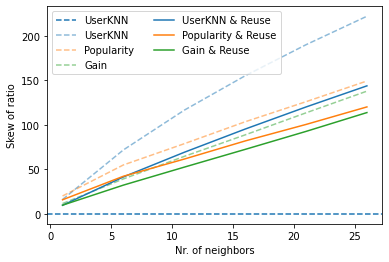

In [381]:
plt.axhline(y=0, color="C0", label="UserKNN", linestyle="dashed")
plt.plot(Ks, [np.mean(list(ratios.values())) for ratios in ratios_userknn], color="C0", label="UserKNN", linestyle="dashed", alpha=0.5)
plt.plot(Ks, [np.mean(list(ratios.values())) for ratios in ratios_popularity], color="C1", label="Popularity", linestyle="dashed", alpha=0.5)
plt.plot(Ks, [np.mean(list(ratios.values())) for ratios in ratios_gain], color="C2", label="Gain", linestyle="dashed", alpha=0.5)
plt.plot(Ks, [np.mean(list(ratios.values())) for ratios in ratios_userknn_reuse], color="C0", label="UserKNN & Reuse")
plt.plot(Ks, [np.mean(list(ratios.values())) for ratios in ratios_popularity_reuse], color="C1", label="Popularity & Reuse")
plt.plot(Ks, [np.mean(list(ratios.values())) for ratios in ratios_gain_reuse], color="C2", label="Gain & Reuse")
plt.ylabel("Skew of ratio")
plt.xlabel("Nr. of neighbors")
plt.legend(ncol=2)

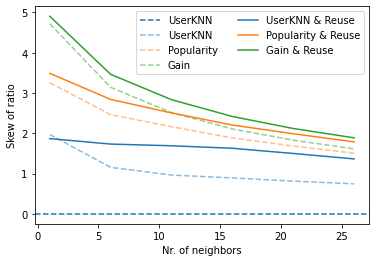

In [376]:
def skew(x):
    x = x#np.abs(np.array(x) - 1)
    return sklearn_skew(x)

plt.axhline(y=0, color="C0", label="UserKNN", linestyle="dashed")
plt.plot(Ks, [skew(list(ratios.values())) for ratios in ratios_userknn], color="C0", label="UserKNN", linestyle="dashed", alpha=0.5)
plt.plot(Ks, [skew(list(ratios.values())) for ratios in ratios_popularity], color="C1", label="Popularity", linestyle="dashed", alpha=0.5)
plt.plot(Ks, [skew(list(ratios.values())) for ratios in ratios_gain], color="C2", label="Gain", linestyle="dashed", alpha=0.5)
plt.plot(Ks, [skew(list(ratios.values())) for ratios in ratios_userknn_reuse], color="C0", label="UserKNN & Reuse")
plt.plot(Ks, [skew(list(ratios.values())) for ratios in ratios_popularity_reuse], color="C1", label="Popularity & Reuse")
plt.plot(Ks, [skew(list(ratios.values())) for ratios in ratios_gain_reuse], color="C2", label="Gain & Reuse")
plt.ylabel("Skew of ratio")
plt.xlabel("Nr. of neighbors")
plt.legend(ncol=2)

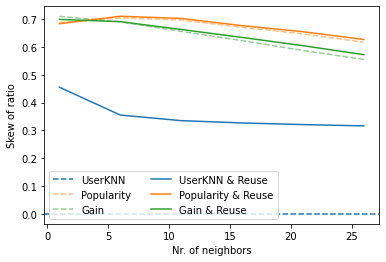

In [377]:
def gini(x):
    x = x#np.abs(np.array(x) - 1)
    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

plt.axhline(y=0, color="C0", label="UserKNN", linestyle="dashed")
plt.plot(Ks, [gini(list(ratios.values())) for ratios in ratios_popularity], color="C1", label="Popularity", linestyle="dashed", alpha=0.5)
plt.plot(Ks, [gini(list(ratios.values())) for ratios in ratios_gain], color="C2", label="Gain", linestyle="dashed", alpha=0.5)
plt.plot(Ks, [gini(list(ratios.values())) for ratios in ratios_userknn_reuse], color="C0", label="UserKNN & Reuse")
plt.plot(Ks, [gini(list(ratios.values())) for ratios in ratios_popularity_reuse], color="C1", label="Popularity & Reuse")
plt.plot(Ks, [gini(list(ratios.values())) for ratios in ratios_gain_reuse], color="C2", label="Gain & Reuse")
plt.ylabel("Skew of ratio")
plt.xlabel("Nr. of neighbors")
plt.legend(ncol=2)

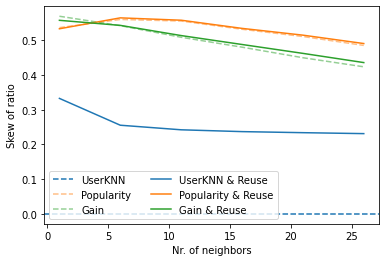

In [378]:
def hoover(x):
    x = x#np.abs(np.array(x) - 1)
    x_ = sorted(x)
    H = 0.5 * np.sum([np.abs(x_[i] - np.mean(x_)) for i in range(len(x_))]) / np.sum(x_)
    return H
    
plt.axhline(y=0, color="C0", label="UserKNN", linestyle="dashed")
plt.plot(Ks, [hoover(list(ratios.values())) for ratios in ratios_popularity], color="C1", label="Popularity", linestyle="dashed", alpha=0.5)
plt.plot(Ks, [hoover(list(ratios.values())) for ratios in ratios_gain], color="C2", label="Gain", linestyle="dashed", alpha=0.5)
plt.plot(Ks, [hoover(list(ratios.values())) for ratios in ratios_userknn_reuse], color="C0", label="UserKNN & Reuse")
plt.plot(Ks, [hoover(list(ratios.values())) for ratios in ratios_popularity_reuse], color="C1", label="Popularity & Reuse")
plt.plot(Ks, [hoover(list(ratios.values())) for ratios in ratios_gain_reuse], color="C2", label="Gain & Reuse")
plt.ylabel("Skew of ratio")
plt.xlabel("Nr. of neighbors")
plt.legend(ncol=2)